# Constants

In [2]:
DATASET_PATH = '../data/dataset_final.csv'

# Imports

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv(DATASET_PATH, header=None)
df.shape

(58302, 1)

# Distribution

In [19]:
code_counts = df[0].apply(lambda x: len(str(x).split(",")))

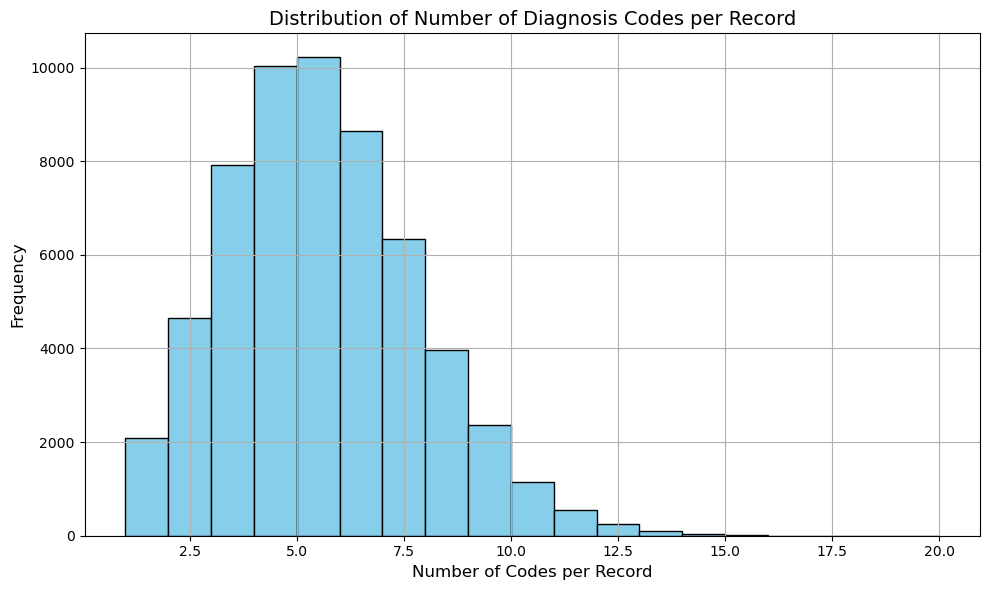

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(code_counts, bins=range(1, max(code_counts)+2), edgecolor='black', color='skyblue')
plt.title("Distribution of Number of Diagnosis Codes per Record", fontsize=14)
plt.xlabel("Number of Codes per Record", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

This histogram shows the distribution of the number of diagnosis codes per patient record in the synthetic dataset. The x-axis represents how many codes appear in a single record (e.g., 5 means that record has 5 diagnosis codes). The y-axis represents the number of records that contain that specific count of codes — i.e., the frequency.

For example:
- At x = 5, the bar height tells us that just under 10,000 records have exactly 5 diagnosis codes.
- At x = 1, about 2,000 records have only 1 code.

Very few records have more than 15 codes — matching the expected right-skewed shape of a Poisson-like distribution.

# Feasibility of identity disclosure

The primary goal of this section is to measure the re-identification risk of patient records based on diagnosis code combinations. The motivation is: If a certain combination of diagnosis codes appears only in one or a few records, that combination can potentially identify individuals uniquely.

So, this section answers: "How likely is it that someone could re-identify a patient based on m diagnosis codes?". The number of records that share a set of m diagnosis codes equals the inverse of the probability of performing identity disclosure, using these codes.

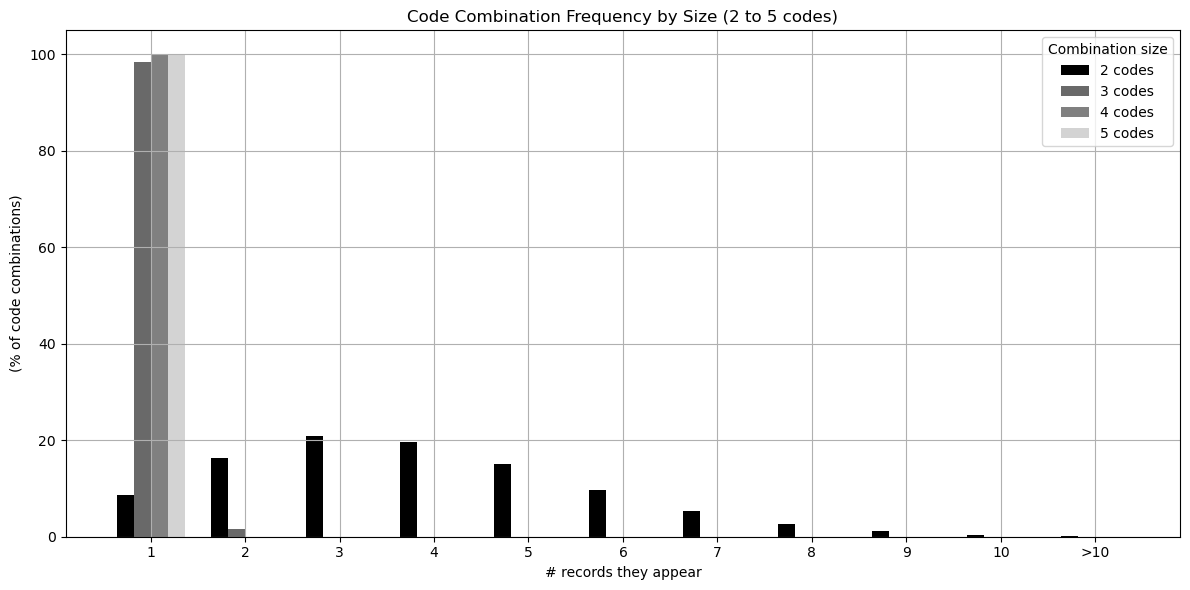

In [33]:
from itertools import combinations # module to generate combinations
# combinations(["A", "B", "C"], 2)
# → ("A", "B"), ("A", "C"), ("B", "C")
from collections import Counter # a dict-like object to count frequencies
# Counter(["x", "y", "x"])
# → Counter({'x': 2, 'y': 1})

# Convert each record (string) to a sorted list of diagnosis codes
records = df[0].astype(str).apply(lambda x: sorted(x.split(","))).tolist()

# Setup plotting parameters
ms = [2, 3, 4, 5]  # combination sizes
colors = ['black', 'dimgray', 'gray', 'lightgray']  # one color per m
x_labels = [str(i) for i in range(1, 11)] + ['>10']
x_indices = np.arange(len(x_labels))  # for proper x-tick alignment
bar_width = 0.18  # width of each bar

# Prepare figure
plt.figure(figsize=(12, 6))
# Initialize a list to hold the summary table values
summary_data = []

# Loop over each m (size of combination)
for i, (m, color) in enumerate(zip(ms, colors)):
    # Counts how many times each m-combination appears in the whole dataset
    combo_counter = Counter()

    # Generate all m-sized code combinations across all records
    for codes in records:
        if len(codes) >= m:
            combo_counter.update(combinations(codes, m))

    # Count how often each combination appears (e.g., 1 time, 2 times, ...)
    freq_counter = Counter(combo_counter.values())

    # Normalize: Convert to percentage of total combinations
    total_combos = sum(freq_counter.values())
    y_vals = [0] * len(x_labels)
    for count, freq in freq_counter.items():
        if count <= 10:
            y_vals[count - 1] += 100 * freq / total_combos
        else:
            y_vals[-1] += 100 * freq / total_combos

    # Offset bars to group side-by-side for each x tick
    offset = (i - 1.5) * bar_width
    positions = x_indices + offset
    plt.bar(positions, y_vals, width=bar_width, color=color, label=f"{m} codes")

    # Prepare summary stats for table
    appear_once = freq_counter[1] / total_combos * 100
    appear_twice = freq_counter[2] / total_combos * 100 if 2 in freq_counter else 0
    appear_three_plus = sum(v for k, v in freq_counter.items() if k >= 3) / total_combos * 100

    summary_data.append({
        "Combination size (m)": m,
        "Appear once (%)": round(appear_once, 2),
        "Appear twice (%)": round(appear_twice, 2),
        "Appear 3+ times (%)": round(appear_three_plus, 2),
    })

# Final plot formatting
plt.xticks(x_indices, x_labels)
plt.xlabel("# records they appear")
plt.ylabel("(% of code combinations)")
plt.title("Code Combination Frequency by Size (2 to 5 codes)")
plt.legend(title="Combination size")
plt.grid(True)
plt.tight_layout()
plt.show()


- The x-axis is the number of records a given combination appears in
- The y-axis is the percentage of all combinations (of m codes) that appear in that many records
- The bars correspond to different values of m (2–5 diagnosis codes)

Sharp drop at x = 1 for m = 4, m = 5
- Nearly 100% of 5-code combinations appear in only one record
- For m = 4, similarly high uniqueness

Smaller m (2, 3):
- These combinations are reused more frequently
- Still, a significant proportion of 2-code combinations appear only once, which implies disclosure risk

<div class="alert alert-block alert-info">
<b>General trend:</b> As m increases, the likelihood that a combination appears more than once drops
</div>

<div class="alert alert-block alert-warning">
<b>Less than 10%:</b> are uniquely re-identifiable, if the dataset is released intact.
</div>

## Summary

In [29]:
# Display summary table
summary_df = pd.DataFrame(summary_data)
summary_df

,Combination size (m),Appear once (%),Appear twice (%),Appear 3+ times (%)
0,2,8.56,16.39,75.05
1,3,98.44,1.55,0.02
2,4,99.99,0.01,0.00
3,5,100.00,0.00,0.00


- For m=2, the majority (75%) appear 3 or more times, risk could be considered moderate in this case.
- For m=3, nearly 98.44% of combinations appear only once. This is a red flag: knowing just 3 diagnosis codes makes almost every patient uniquely identifiable
- For m=4 and m=5, virtually every combination is unique. This is maximum identity disclosure risk: An attacker with knowledge of just 4–5 diagnoses can re-identify someone with near certainty.

These results suggest:
- The dataset, while realistic, might lack overlap in diagnosis profiles.
- More importantly: it confirms that identity disclosure risk is high, even in synthetic datasets that mimic real data distribution.

## Toy Example

In [35]:
# Sample records (each is a list of diagnosis codes)
records = [
    ["A", "B", "C"],
    ["A", "B", "D"]
]

# Combination size
m = 2

# Initialize counter
combo_counter = Counter()

# Process each record
for idx, codes in enumerate(records):
    print(f"\nRecord {idx+1}: {codes}")
    
    # Generate m-combinations
    combos = list(combinations(codes, m))
    print(f"  m={m} combinations: {combos}")
    
    # Update counter
    combo_counter.update(combos)
    print(f"  Counter after update: {dict(combo_counter)}")

# Final result
print("\n Final combo_counter:")
for combo, count in combo_counter.items():
    print(f"  {combo}: {count}")


Record 1: ['A', 'B', 'C']
  m=2 combinations: [('A', 'B'), ('A', 'C'), ('B', 'C')]
  Counter after update: {('A', 'B'): 1, ('A', 'C'): 1, ('B', 'C'): 1}

Record 2: ['A', 'B', 'D']
  m=2 combinations: [('A', 'B'), ('A', 'D'), ('B', 'D')]
  Counter after update: {('A', 'B'): 2, ('A', 'C'): 1, ('B', 'C'): 1, ('A', 'D'): 1, ('B', 'D'): 1}

 Final combo_counter:
  ('A', 'B'): 2
  ('A', 'C'): 1
  ('B', 'C'): 1
  ('A', 'D'): 1
  ('B', 'D'): 1


# Experimental data and setup

# Supporting clinical case count studies

# Effectiveness in medical analytic tasks